%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install evaluate

# Image Classification Model
In this notebook we implement the model which will be used to provide a classification for the art pieces that we provide. The model implemented is a visual Transformer, which takes the label of the image and the image itself and provides one of the chosen classifications.
 

In [18]:
import pandas as pd
import torch
import torchvision
import numpy as np
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Label Tokenization
To facilitate feeding labels into the model, we tokenize them by pairing each unique label with a corresponding index. For instance:
- **Label**: "Leonardo DaVinci" -> **ID**: 3



In [2]:
import json

data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
data = data[:20000]
data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TECHNIQUE':'style'})
data = data[['image','author','style']]
data['image'] = [f'.{x}' for x in data['image']]
data['author'] = [x.lower() for x in data['author']]
data['style'] = [x.split(',')[0].lower() for x in data['style']]

with open('../label_author.json', 'r') as f:
    labels_author = json.load(f)
label2id_auth, id2label_auth = dict(), dict()
for i, label in labels_author.items():
    i= int(i)
    id2label_auth[i]=label
    label2id_auth[label]=i

with open('../label_style.json', 'r') as f:
    labels_sty = json.load(f)
label2id_sty, id2label_sty = dict(), dict()
for i, label in labels_sty.items():
    i=int(i)
    label2id_sty[label]=i
    id2label_sty[i]=label

In [3]:
data.head()

,image,author,style
0,../images/21751.jpg,"lippi, fra filippo",pen and ink
1,../images/38982.jpg,"tura, cosmè",tempera on wood
2,../images/37005.jpg,"strozzi, bernardo",oil on canvas
3,../images/22645.jpg,"machy, pierre-antoine de",oil on canvas
4,../images/41512.jpg,"veronese, paolo",oil on canvas


In [4]:
data['author'] = data['author'].map(label2id_auth)
data['style'] = data['style'].map(label2id_sty)
data.columns

Index(['image', 'author', 'style'], dtype='object')

### Image Processing
Achieving optimal results from our model necessitates preprocessing the images. Key steps in this process include:

#### Standardization
To enable image normalization, we compute both the **mean** and the **standard deviation** of the images. Since image sizes can vary, we first standardize them by resizing all images to a uniform size of 256x256 pixels.

#### Mean and Standard Deviation Calculation
We calculate the mean and standard deviation of the images to aid in normalization. This statistical information is crucial for ensuring consistent and effective preprocessing across the dataset.

#### Transformation Pipeline
The actual image processing is orchestrated using the `Compose` function from the `transforms` library. This function allows us to construct a pipeline of operations to be applied to each image systematically. By automating this process across the entire dataset, we ensure consistency and efficiency in image preprocessing.

### Transformation Details
We define separate transformation pipelines for both training and testing datasets, encompassing operations such as resizing, center cropping, converting to tensors, and normalization. Additionally, for the training dataset, we incorporate data augmentation techniques such as random rotation and horizontal flipping to enhance the model's robustness and generalization ability.


In [5]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(256),
    transforms.ToTensor(),
])

img_tr = [transform(Image.open(img)) for img in tqdm(data['image'])]

mean,std = img_tr[0].mean(),img_tr[0].std()

100%|██████████| 20000/20000 [03:43<00:00, 89.37it/s] 


In [6]:
mean,std = img_tr[0].mean([1,2]),img_tr[0].std([1,2])
print("mean and std before normalize:")
print("Mean of the image:", mean)
print("Std of the image:", std)

mean and std before normalize:
Mean of the image: tensor([0.5845, 0.5639, 0.5761])
Std of the image: tensor([0.1066, 0.1094, 0.1097])


In [7]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    ])

class ArtDataset(torch.utils.data.Dataset):

    def __init__(self,images,labels,transform=None,):
        self.data = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_pil = Image.open(self.data[index])
        img_pil = img_pil.convert('RGB')
        if self.transform is not None:
            img_pil = self.transform(img_pil)
        label = torch.tensor(self.labels[index])
        return(img_pil,label)

## Author Train and Eval data

In [8]:
# Split train into train and val for the author lable
X_train_auth, X_val_auth, y_train_auth, y_val_auth = train_test_split(data['image'],data['author'], test_size=0.2, random_state=42)
train_dataset_auth = ArtDataset(X_train_auth.values,y_train_auth.values,transform=train_transform)
val_dataset_auth = ArtDataset(X_val_auth.values,y_val_auth.values,transform=test_transform)

## Style Train and Eval data

In [9]:
# Split train into train and val for the author lable
X_train_style, X_val_style, y_train_style, y_val_style = train_test_split(data['image'],data['style'], test_size=0.2, random_state=42)
train_dataset_style = ArtDataset(X_train_style.values,y_train_style.values,transform=train_transform)
val_dataset_style = ArtDataset(X_val_style.values,y_val_style.values,transform=test_transform)

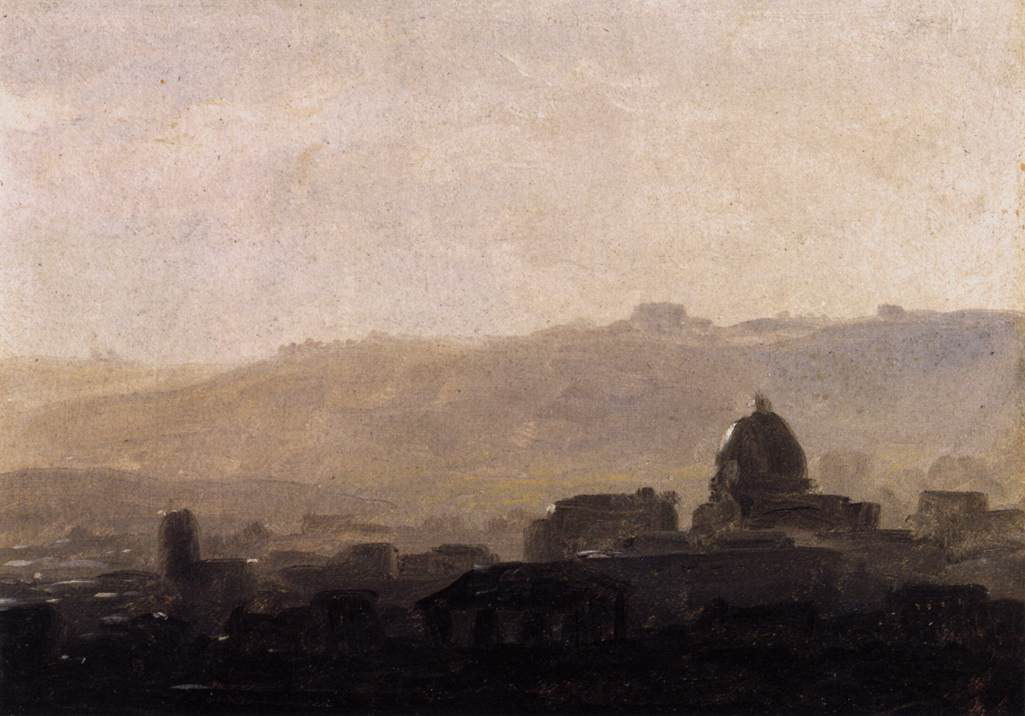

Author: valenciennes, pierre-henri de
Style: oil on paper laid on board


In [10]:
image = train_dataset_auth.data[0]
author = train_dataset_auth.labels[0]
sty = train_dataset_style.labels[0]
display(Image.open(image))
print(f"Author: {id2label_auth[author]}")
print(f"Style: {id2label_sty[sty]}")

## The Model

Regarding the model, we decided to go with a Convolutional Neural Network (CNN) augmented with visual attention mechanisms.

### AttentionBlock

To enhance the model's ability to focus on relevant regions within the input images, we designed and implemented the AttentionBlock. This component enables the network to dynamically adjust the importance of local features based on their relevance to the task at hand. By incorporating attention mechanisms, we aimed to improve the model's discriminative power and performance, particularly in scenarios where selective feature attention is beneficial.


In [11]:
class AttentionBlock(nn.Module):
    def __init__(self, in_features_l, in_features_g, attn_features, up_factor, normalize_attn=True):
        super(AttentionBlock, self).__init__()
        self.up_factor = up_factor
        self.normalize_attn = normalize_attn
        self.W_l = nn.Conv2d(in_channels=in_features_l, out_channels=attn_features, kernel_size=3, padding=1, bias=False)
        self.W_g = nn.Conv2d(in_channels=in_features_g, out_channels=attn_features, kernel_size=3, padding=1, bias=False)
        self.phi = nn.Conv2d(in_channels=attn_features, out_channels=1, kernel_size=1, padding=0, bias=True)
        
    def forward(self, l, g):
        N, C, W, H = l.size()
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        g_ = F.interpolate(g_, size=(W, H), mode='bilinear', align_corners=False)
        c = self.phi(F.relu(l_ + g_)) # batch_sizex1xWxH
        
        # compute attn map
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        else:
            a = torch.sigmoid(c)
        # re-weight the local feature
        f = torch.mul(a.expand_as(l), l) # batch_sizexCxWxH
        if self.normalize_attn:
            output = f.view(N,C,-1).sum(dim=2) # weighted sum
        else:
            output = F.adaptive_avg_pool2d(f, (1,1)).view(N,C) # global average pooling
        return a, output

### Transfer Learning with VGG16

Initially, we attempted to implement the VGG network architecture from scratch. However, due to the computational complexity and time constraints associated with training such a deep network, we opted for transfer learning. Specifically, we leveraged the pre-trained VGG16 model as our base network.

By utilizing transfer learning, we could benefit from the features learned by VGG16 on a large dataset (e.g., ImageNet) and focus our efforts on fine-tuning the model for our specific task. This approach significantly reduced the training time and computational resources required while still enabling us to achieve satisfactory performance.


In [12]:
# #VGG
# class VGG(nn.Module):
#     def __init__(self, num_classes):
#         super(VGG,self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
#         self.layer6 = nn.Sequential(
#             nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
#         self.layer7 = nn.Sequential(
#             nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer8 = nn.Sequential(
#             nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer9 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer10 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         self.layer11 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer12 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
#         self.layer13 = nn.Sequential(
#             nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2)
#         )
#         # self.fc = nn.Sequential(
#         #     nn.Dropout(0.5),
#         #     nn.Linear(7*7*512,4096),
#         #     nn.ReLU(),
#         # )
#         # self.fc1 = nn.Sequential(
#         #     nn.Dropout(0.5),
#         #     nn.Linear(4,4096),
#         #     nn.ReLU(),
#         # )
#         # self.fc2 = nn.Sequential(
#         #     nn.Linear (4096, num_classes))
        
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = self.layer6(x)
#         l = self.layer7(x)
#         x = self.layer8(l)
#         x = self.layer9(x)
#         x = self.layer10(x)
#         x = self.layer11(x)
#         x = self.layer12(x)
#         g = self.layer13(x)
#         x = x.reshape(x.size(0),-1)
#         # x = self.fc(x)
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         return x

### Construction of Our Model

Building upon the VGG16 base, we constructed our network by adding additional layers and incorporating attention mechanisms. This allowed us to tailor the model to our particular classification task while capitalizing on the robust feature extraction capabilities of VGG16.


### Benefits of Transfer Learning and Attention Mechanisms

Utilizing transfer learning with VGG16 and integrating attention mechanisms provided several advantages:
- **Time Efficiency:** Transfer learning expedited the model development process by leveraging pre-trained weights, reducing the need for extensive training on our dataset.
- **Performance Enhancement:** Attention mechanisms allowed the model to focus on salient features, potentially improving classification accuracy and robustness.
- **Resource Conservation:** By reusing pre-trained weights and incorporating attention mechanisms, we optimized resource utilization, making the model more practical for deployment in resource-constrained environments.


In [13]:
class ArtCNN(nn.Module):
    def __init__(self, num_classes, normalize_attn=False, dropout=None):
        super(ArtCNN, self).__init__()
        net = torchvision.models.vgg19_bn(weights=torchvision.models.VGG19_BN_Weights.DEFAULT)
        self.conv_block1 = nn.Sequential(*list(net.features.children())[0:6])
        self.conv_block2 = nn.Sequential(*list(net.features.children())[7:13])
        self.conv_block3 = nn.Sequential(*list(net.features.children())[14:23])
        self.conv_block4 = nn.Sequential(*list(net.features.children())[24:33])
        self.conv_block5 = nn.Sequential(*list(net.features.children())[34:43])
        self.pool = nn.AdaptiveAvgPool2d(7)
        self.dpt = None
        if dropout is not None:
            self.dpt = nn.Dropout(dropout)
        self.cls = nn.Linear(in_features=25856, out_features=num_classes, bias=True)
        
       # initialize the attention blocks defined above
        self.attn1 = AttentionBlock(256, 512, 256, 8, normalize_attn=normalize_attn)
        self.attn2 = AttentionBlock(512, 512, 256, 4, normalize_attn=normalize_attn)
        
    def forward(self, x):
        block1 = self.conv_block1(x)       # /1
        pool1 = F.max_pool2d(block1, 2, 2) # /2
        block2 = self.conv_block2(pool1)   # /2
        pool2 = F.max_pool2d(block2, 2, 2) # /4
        block3 = self.conv_block3(pool2)   # /4
        pool3 = F.max_pool2d(block3, 2, 2) # /8
        block4 = self.conv_block4(pool3)   # /8
        pool4 = F.max_pool2d(block4, 2, 2) # /16
        block5 = self.conv_block5(pool4)   # /16
        pool5 = F.max_pool2d(block5, 2, 2) # /32
        N, __, __, __ = pool5.size()
        g = self.pool(pool5).view(N,-1)
        a1, g1 = self.attn1(pool3, pool5)
        a2, g2 = self.attn2(pool4, pool5)
        g_hat = torch.cat((g,g1,g2), dim=1) # batch_size x C
        if self.dpt is not None:
            g_hat = self.dpt(g_hat)
        out = self.cls(g_hat)

        return [out, a1, a2]

In [14]:
def train_and_evaluate(model, optimizer, criterion, train_loader, val_loader, epochs=10):
    
    with tqdm(total=epochs) as pbar:
        for _ in range(epochs):
            # Training phase
            model.train()
            for _, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs, _, _ = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            pbar.update(1)
        correct = 0
        total = 0
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs,_,_ = model(images)
                loss = criterion(outputs,labels)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total
    print(f'Accuracy: {accuracy}%')
    return accuracy

In [15]:
def calculate_accuracy(val_loader, model, criterion, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs,_,_ = model(images)
            loss = criterion(outputs,labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total
    print(f'Accuracy: {accuracy}%')
    return accuracy

In [16]:
def train(model, optimizer, criterion, train_loader, val_loader, epochs=10, early_stopping_patience=25):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    with tqdm(total=epochs) as pbar:
        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for _, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs, _, _ = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(train_loader))

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data in val_loader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs, _, _ = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                val_losses.append(val_loss / len(val_loader))

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch + 1}')
                    break

            # Update progress bar
            pbar.set_description(f'Train loss: {train_losses[-1]:.3f} | Val loss: {val_losses[-1]:.3f}')
            pbar.update(1)

    return train_losses, val_losses

### Hyperparameters Search

To get the best hyperparameters for each model we decided to use the Optuna Library. This library is a hyperparameter optimization framework applicable to machine learning models. It has been designed with a focus on simplicity and ease of use, while still providing a wide range of features and capabilities. Optuna is a popular choice for hyperparameter optimization due to its flexibility, scalability. It also supports a variety of use cases, including traditional machine learning models, deep learning models, and more.
 

In [17]:
def objective_auth(trial):
    # Define search space for hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4,log=True)
    epochs = trial.suggest_int('epochs', 5, 50)
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)

    # Train the model with current hyperparameters
    model = ArtCNN(num_classes=len(labels_author), dropout=dropout_rate).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset_auth, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_auth, batch_size=batch_size, shuffle=False)
    _, val_loss = train(model, optimizer, criterion, train_loader, val_loader, epochs = epochs, early_stopping_patience=early_stopping_patience)
    accuracy = calculate_accuracy(val_loader, model, criterion, device)

    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_auth, n_trials=10)

# Get the best hyperparameters and accuracy
best_params_auth = study.best_params
best_accuracy_auth = study.best_value
#{'learning_rate': 5.1481519513568155e-05, 'batch_size': 32, 'dropout_rate': 0.25189548904234554, 'weight_decay': 3.701365753127736e-05, 'epochs': 24, 'early_stopping_patience': 17}
print("Best hyperparameters Author:", best_params_auth)
print("Best accuracy Author:", best_accuracy_auth)
torch.cuda.empty_cache()

[I 2024-05-03 10:03:15,002] A new study created in memory with name: no-name-3273d738-a046-4757-8b23-d3a312a1a0fd
Train loss: 5.984 | Val loss: 7.400:  42%|████▏     | 16/38 [1:43:20<2:22:05, 387.51s/it]

Early stopping at epoch 17



[I 2024-05-03 11:47:40,050] Trial 0 finished with value: 5.0 and parameters: {'learning_rate': 0.005823431712228729, 'batch_size': 32, 'dropout_rate': 0.44740794137877915, 'weight_decay': 3.378167303534728e-06, 'epochs': 38, 'early_stopping_patience': 15}. Best is trial 0 with value: 5.0.


Accuracy: 5%


Train loss: 0.108 | Val loss: 8.655:  79%|███████▉  | 19/24 [2:00:14<31:38, 379.71s/it]  

Early stopping at epoch 20



[I 2024-05-03 13:48:55,341] Trial 1 finished with value: 23.0 and parameters: {'learning_rate': 5.1481519513568155e-05, 'batch_size': 32, 'dropout_rate': 0.25189548904234554, 'weight_decay': 3.701365753127736e-05, 'epochs': 24, 'early_stopping_patience': 17}. Best is trial 1 with value: 23.0.


Accuracy: 23%


Train loss: 5.992 | Val loss: 7.880:  53%|█████▎    | 20/38 [5:37:56<5:04:08, 1013.81s/it]

Early stopping at epoch 21



[I 2024-05-03 19:27:49,940] Trial 2 finished with value: 5.0 and parameters: {'learning_rate': 0.009941551655810819, 'batch_size': 64, 'dropout_rate': 0.4853132854882083, 'weight_decay': 3.806129178781603e-06, 'epochs': 38, 'early_stopping_patience': 10}. Best is trial 1 with value: 23.0.


Accuracy: 5%


Train loss: 4.797 | Val loss: 8.334:  37%|███▋      | 11/30 [1:09:21<1:59:48, 378.33s/it]

Early stopping at epoch 12



[I 2024-05-03 20:38:10,064] Trial 3 finished with value: 9.0 and parameters: {'learning_rate': 0.0017353868597111688, 'batch_size': 32, 'dropout_rate': 0.14902679466833876, 'weight_decay': 3.119035446595421e-06, 'epochs': 30, 'early_stopping_patience': 9}. Best is trial 1 with value: 23.0.


Accuracy: 9%


Train loss: 5.307 | Val loss: 7.594:  32%|███▏      | 10/31 [1:03:41<2:13:46, 382.20s/it]

Early stopping at epoch 11



[I 2024-05-03 21:42:50,575] Trial 4 finished with value: 8.0 and parameters: {'learning_rate': 0.0022746605525523628, 'batch_size': 32, 'dropout_rate': 0.21835800427479668, 'weight_decay': 1.3232847341566767e-06, 'epochs': 31, 'early_stopping_patience': 8}. Best is trial 1 with value: 23.0.


Accuracy: 8%


Train loss: 0.983 | Val loss: 7.061:  80%|████████  | 24/30 [4:44:08<1:11:02, 710.34s/it] 

Early stopping at epoch 25



[I 2024-05-04 02:28:05,023] Trial 5 finished with value: 21.0 and parameters: {'learning_rate': 1.0233226024216982e-05, 'batch_size': 32, 'dropout_rate': 0.2924465235460965, 'weight_decay': 3.362463630112872e-06, 'epochs': 30, 'early_stopping_patience': 17}. Best is trial 1 with value: 23.0.


Accuracy: 21%


Train loss: 1.249 | Val loss: 6.318:  30%|███       | 15/50 [4:01:53<9:24:24, 967.57s/it] 

Early stopping at epoch 16



[I 2024-05-04 06:31:03,976] Trial 6 finished with value: 21.0 and parameters: {'learning_rate': 1.8916210455600714e-05, 'batch_size': 64, 'dropout_rate': 0.18783278182333124, 'weight_decay': 1.8636333096804312e-05, 'epochs': 50, 'early_stopping_patience': 6}. Best is trial 1 with value: 23.0.


Accuracy: 21%


Train loss: 7.234 | Val loss: 7.881:  75%|███████▌  | 6/8 [50:05<16:41, 500.95s/it]

Early stopping at epoch 7



[I 2024-05-04 07:22:15,260] Trial 7 finished with value: 1.0 and parameters: {'learning_rate': 0.07634365757570821, 'batch_size': 32, 'dropout_rate': 0.13292613411322196, 'weight_decay': 3.85906904193073e-06, 'epochs': 8, 'early_stopping_patience': 6}. Best is trial 1 with value: 23.0.


Accuracy: 1%


Train loss: 7.292 | Val loss: 8.035:  24%|██▍       | 11/46 [1:25:49<4:33:03, 468.10s/it]

Early stopping at epoch 12



[I 2024-05-04 08:49:09,998] Trial 8 finished with value: 1.0 and parameters: {'learning_rate': 0.07984653193771785, 'batch_size': 32, 'dropout_rate': 0.415877702800975, 'weight_decay': 2.0918014544968188e-05, 'epochs': 46, 'early_stopping_patience': 11}. Best is trial 1 with value: 23.0.


Accuracy: 1%


Train loss: 5.254 | Val loss: 7.397: 100%|██████████| 9/9 [1:04:28<00:00, 429.88s/it]
[I 2024-05-04 09:54:44,483] Trial 9 finished with value: 8.0 and parameters: {'learning_rate': 0.0010982022857425515, 'batch_size': 32, 'dropout_rate': 0.27223938096336797, 'weight_decay': 2.308395885177375e-06, 'epochs': 9, 'early_stopping_patience': 9}. Best is trial 1 with value: 23.0.


Accuracy: 8%
Best hyperparameters Author: {'learning_rate': 5.1481519513568155e-05, 'batch_size': 32, 'dropout_rate': 0.25189548904234554, 'weight_decay': 3.701365753127736e-05, 'epochs': 24, 'early_stopping_patience': 17}
Best accuracy Author: 23.0


In [19]:
def objective_style(trial):
    # Define search space for hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1,log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-4,log=True)
    epochs = trial.suggest_int('epochs', 5, 50)
    early_stopping_patience = trial.suggest_int('early_stopping_patience', 5, 20)

    # Train the model with current hyperparameters
    model = ArtCNN(num_classes=len(labels_sty), dropout=dropout_rate).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    train_loader = DataLoader(train_dataset_style, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset_style, batch_size=batch_size, shuffle=False)
    _, val_loss = train(model, optimizer, criterion, train_loader, val_loader, epochs = epochs, early_stopping_patience=early_stopping_patience)
    accuracy = calculate_accuracy(val_loader, model, criterion, device)


    return accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective_style, n_trials=100)

# Get the best hyperparameters and accuracy
best_params_sty = study.best_params
best_accuracy_sty = study.best_value

print("Best hyperparameters Style:", best_params_sty)
print("Best accuracy Style:", best_accuracy_sty)
torch.cuda.empty_cache()

[I 2024-05-05 12:48:06,106] A new study created in memory with name: no-name-5effa1ba-085e-4234-bc71-766cd1a23cf9
Train loss: 1.960 | Val loss: 3.118: 100%|██████████| 14/14 [2:38:13<00:00, 678.14s/it] 
[I 2024-05-05 15:27:21,422] Trial 0 finished with value: 48.0 and parameters: {'learning_rate': 0.007598233087202921, 'batch_size': 64, 'dropout_rate': 0.2650093703158096, 'weight_decay': 3.3247756671986375e-05, 'epochs': 14, 'early_stopping_patience': 15}. Best is trial 0 with value: 48.0.


Accuracy: 48%


Train loss: 0.795 | Val loss: 2.704: 100%|██████████| 9/9 [1:19:44<00:00, 531.65s/it]
[I 2024-05-05 16:48:06,587] Trial 1 finished with value: 55.0 and parameters: {'learning_rate': 8.685275030581731e-05, 'batch_size': 32, 'dropout_rate': 0.36761097642124807, 'weight_decay': 4.033402981080324e-06, 'epochs': 9, 'early_stopping_patience': 8}. Best is trial 1 with value: 55.0.


Accuracy: 55%


Train loss: 2.455 | Val loss: 2.980: 100%|██████████| 6/6 [1:01:46<00:00, 617.67s/it]
[I 2024-05-05 17:50:52,182] Trial 2 finished with value: 47.0 and parameters: {'learning_rate': 0.01315862700551417, 'batch_size': 64, 'dropout_rate': 0.11359891332350239, 'weight_decay': 7.409744633937498e-06, 'epochs': 6, 'early_stopping_patience': 7}. Best is trial 1 with value: 55.0.


Accuracy: 47%


Train loss: 1.314 | Val loss: 2.645:  18%|█▊        | 8/44 [1:32:37<6:56:47, 694.65s/it]

Early stopping at epoch 9



[I 2024-05-05 19:24:29,276] Trial 3 finished with value: 54.0 and parameters: {'learning_rate': 0.00034362611223412047, 'batch_size': 64, 'dropout_rate': 0.4664566619571543, 'weight_decay': 1.3100673307987084e-05, 'epochs': 44, 'early_stopping_patience': 6}. Best is trial 1 with value: 55.0.


Accuracy: 54%


Train loss: 0.660 | Val loss: 2.790:  28%|██▊       | 13/47 [2:03:00<5:21:43, 567.76s/it]

Early stopping at epoch 14



[I 2024-05-05 21:28:30,185] Trial 4 finished with value: 56.0 and parameters: {'learning_rate': 4.17906402460959e-05, 'batch_size': 32, 'dropout_rate': 0.4760821225039382, 'weight_decay': 7.640373067082714e-06, 'epochs': 47, 'early_stopping_patience': 7}. Best is trial 4 with value: 56.0.


Accuracy: 56%


Train loss: 0.764 | Val loss: 3.135:  44%|████▍     | 12/27 [2:13:49<2:47:17, 669.17s/it]

Early stopping at epoch 13



[I 2024-05-05 23:43:19,816] Trial 5 finished with value: 49.0 and parameters: {'learning_rate': 0.0005640266892587838, 'batch_size': 64, 'dropout_rate': 0.3655365908058761, 'weight_decay': 2.201079050276503e-05, 'epochs': 27, 'early_stopping_patience': 8}. Best is trial 4 with value: 56.0.


Accuracy: 49%


Train loss: 2.229 | Val loss: 2.879:  64%|██████▍   | 9/14 [1:46:35<59:13, 710.61s/it]  

Early stopping at epoch 10



[I 2024-05-06 01:31:01,591] Trial 6 finished with value: 48.0 and parameters: {'learning_rate': 0.0062597679558948184, 'batch_size': 64, 'dropout_rate': 0.3110256125934413, 'weight_decay': 4.134294489517387e-05, 'epochs': 14, 'early_stopping_patience': 6}. Best is trial 4 with value: 56.0.


Accuracy: 48%


Train loss: 1.181 | Val loss: 2.970:  31%|███       | 11/36 [1:45:17<3:59:18, 574.35s/it]

Early stopping at epoch 12



[I 2024-05-06 03:17:17,684] Trial 7 finished with value: 53.0 and parameters: {'learning_rate': 0.00047454982009835544, 'batch_size': 32, 'dropout_rate': 0.21804579455589318, 'weight_decay': 4.4492955233934755e-06, 'epochs': 36, 'early_stopping_patience': 8}. Best is trial 4 with value: 56.0.


Accuracy: 53%


Train loss: 2.044 | Val loss: 2.891: 100%|██████████| 11/11 [1:33:02<00:00, 507.51s/it]
[I 2024-05-06 04:51:18,407] Trial 8 finished with value: 51.0 and parameters: {'learning_rate': 0.0033243600013510267, 'batch_size': 32, 'dropout_rate': 0.18838269419681244, 'weight_decay': 1.979348008178952e-06, 'epochs': 11, 'early_stopping_patience': 19}. Best is trial 4 with value: 56.0.


Accuracy: 51%


Train loss: 3.102 | Val loss: 3.453: 100%|██████████| 9/9 [1:16:06<00:00, 507.40s/it]
[I 2024-05-06 06:08:23,229] Trial 9 finished with value: 37.0 and parameters: {'learning_rate': 0.03529999033291016, 'batch_size': 32, 'dropout_rate': 0.4385484273476632, 'weight_decay': 3.5645351991330073e-06, 'epochs': 9, 'early_stopping_patience': 18}. Best is trial 4 with value: 56.0.


Accuracy: 37%


Train loss: 1.175 | Val loss: 2.609:  42%|████▏     | 21/50 [3:09:00<4:21:00, 540.03s/it]

Early stopping at epoch 22



[I 2024-05-06 09:18:25,891] Trial 10 finished with value: 57.0 and parameters: {'learning_rate': 1.0225636410036674e-05, 'batch_size': 32, 'dropout_rate': 0.4978375095238207, 'weight_decay': 1.1995772075099324e-06, 'epochs': 50, 'early_stopping_patience': 12}. Best is trial 10 with value: 57.0.


Accuracy: 57%


  0%|          | 0/50 [01:48<?, ?it/s]
[W 2024-05-06 09:20:15,213] Trial 11 failed with parameters: {'learning_rate': 1.1506439845748787e-05, 'batch_size': 32, 'dropout_rate': 0.4959258164528443, 'weight_decay': 1.0120252096351077e-06, 'epochs': 50, 'early_stopping_patience': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Fede\AppData\Local\Temp\ipykernel_23236\3507063943.py", line 16, in objective_style
    _, val_loss = train(model, optimizer, criterion, train_loader, val_loader, epochs = epochs, early_stopping_patience=early_stopping_patience)
  File "C:\Users\Fede\AppData\Local\Temp\ipykernel_23236\2185303138.py", line 19, in train
    train_loss += loss.item()
KeyboardInterrupt
[W 2024-05-06 09:20:15,229] Trial 11 failed with value None.


KeyboardInterrupt: 

In [ ]:
# #Hyperparameters Grid Search
# from itertools import product
 
# learning_rates = [0.1, 0.01, 0.001,0.0001]
# weight_decays = [0.1, 0.01, 0.001,0.0001]
# dropouts = [0.2, 0.3,0.5]
# batch_sizes = [32, 64]

# best_accuracy = 0
# best_learning_rate = 0
# for lr, batch_size, dropout_rate, weight_decay in product(learning_rates, batch_sizes, dropouts, weight_decays):
#     model = ArtCNN(num_classes=len(labels_auth), normalize_attn=True, dropout=dropout_rate)
#     model.to(device)
#     train_loader = DataLoader(train_dataset_auth, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset_auth, batch_size=batch_size, shuffle=False)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#     accuracy,_,_ = train_and_evaluate(model, optimizer, nn.CrossEntropyLoss(), train_loader, val_loader)
#     if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_learning_rate = lr
#         best_batch_size = batch_size
#         best_dropout_rate = dropout_rate
#         best_weight_decay = weight_decay
# print(f'Best accuracy: {best_accuracy}, Best learning rate: {best_learning_rate}, Best batch size: {best_batch_size}, Best dropout rate: {best_dropout_rate}, Best weight decay: {best_weight_decay}')

## Create Dataloader

In [ ]:
if not best_params_auth:
    best_params_auth = {'learning_rate': 5.1481519513568155e-05, 'batch_size': 32, 'dropout_rate': 0.25189548904234554, 'weight_decay': 3.701365753127736e-05, 'epochs': 24, 'early_stopping_patience': 17}
if not best_accuracy_sty:
    best_params_sty = {'learning_rate': 1.0225636410036674e-05, 'batch_size': 32, 'dropout_rate': 0.4978375095238207, 'weight_decay': 1.1995772075099324e-06, 'epochs': 50, 'early_stopping_patience': 12}
    
trainloader_auth = DataLoader(train_dataset_auth, batch_size=best_params_auth['batch_size'], shuffle=True)
testloader_auth = DataLoader(val_dataset_auth, batch_size=best_params_auth['batch_size'], shuffle=False)
trainloader_style = DataLoader(train_dataset_style, batch_size=best_params_sty['batch_size'], shuffle=True)
testloader_style = DataLoader(val_dataset_style, batch_size=best_params_sty['batch_size'], shuffle=False)

In [ ]:
features, labels = next(iter(trainloader_auth))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze().permute(1, 2, 0)
label = labels[0]
plt.imshow(img)
plt.show()
print(f"Author: {labels_author[label]}")

TypeError: new(): invalid data type 'str'

In [ ]:
model_auth = ArtCNN(len(labels_author),dropout=best_params_auth['dropout']).to(device)
model_style = ArtCNN(len(labels_sty),dropout=best_params_sty['dropout']).to(device)

### Choice of Loss Function and Optimizer

The selection of the loss function and optimizer is crucial for effective training and optimization of the neural network. Here's why these specific components are used:

1. **Cross-Entropy Loss**:
   - **Applicability**: The model is designed for a classification task, aiming to categorize input images into different classes (e.g., identifying the artist of a painting). Cross-entropy loss is a standard choice for such tasks as it quantifies the disparity between predicted and true class distributions.
   - **Compatibility**: The model outputs class probabilities through a softmax layer followed by a linear classification layer. Cross-entropy loss is well-suited for computing the error between predicted probabilities and ground truth labels.
   - **Training Objective**: Minimizing cross-entropy loss drives the model to learn meaningful representations of the input data and make accurate predictions.

2. **AdamW Optimizer**:
   - **Adaptive Learning Rate**: AdamW is renowned for its adaptive learning rate capabilities, making it suitable for training deep neural networks with complex architectures. It adjusts the learning rate for each parameter individually based on gradient magnitudes, facilitating efficient convergence.
   - **Weight Decay**: The AdamW optimizer incorporates weight decay, a form of regularization that penalizes large parameter values. This helps prevent overfitting by encouraging the model to learn simpler and more generalizable representations.
   - **Robustness**: AdamW is known to perform well across a wide range of tasks and architectures, making it a popular choice for training neural networks.
   - **Stability**: By maintaining separate adaptive learning rates for each parameter, AdamW navigates through complex optimization landscapes more effectively, leading to faster convergence and improved stability during training.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_auth = optim.AdamW(model_auth.parameters(),lr=best_params_auth['learning_rate'], weight_decay=best_params_auth['weight_decay'])
optimizer_style = optim.AdamW(model_style.parameters(),lr=best_params_sty['learning_rate'], weight_decay=best_params_sty['weight_decay'])

# Models Training

In [ ]:
print('Training the model for author...')
auth_train_losses, auth_test_loss = train(model_auth, optimizer_auth, criterion, trainloader_auth, testloader_auth, epochs=best_params_auth['epochs'], early_stopping_patience=best_params_auth['early_stopping_patience'])
print('Training the model for style...')
style_train_losses, style_test_loss = train(model_style, optimizer_style, criterion, trainloader_style, testloader_style, epochs=best_params_sty['epochs'],early_stopping_patience=best_params_sty['early_stopping_patience'])

Training the model for author...


Train loss: 0.062 | Val loss: 6.296:  28%|██▊       | 28/100 [4:26:50<11:26:09, 571.80s/it]


Early stopping at epoch 29
Training the model for style...


Train loss: 0.035 | Val loss: 3.282:  29%|██▉       | 29/100 [4:04:48<9:59:22, 506.51s/it] 


Early stopping at epoch 30
Training the model for title...


Train loss: 2.350 | Val loss: 10.695:   5%|▌         | 5/100 [1:02:52<19:54:42, 754.55s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(loss_values, title="Loss Plot"):
    """
    Plot the loss values over training epochs.

    Parameters:
    - loss_values: A list or array of loss values for each epoch.
    - title: The title of the plot (optional).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_values[0], marker='o', linestyle='-', label='train')
    plt.plot(loss_values[1], marker='o', linestyle='-',label='val')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

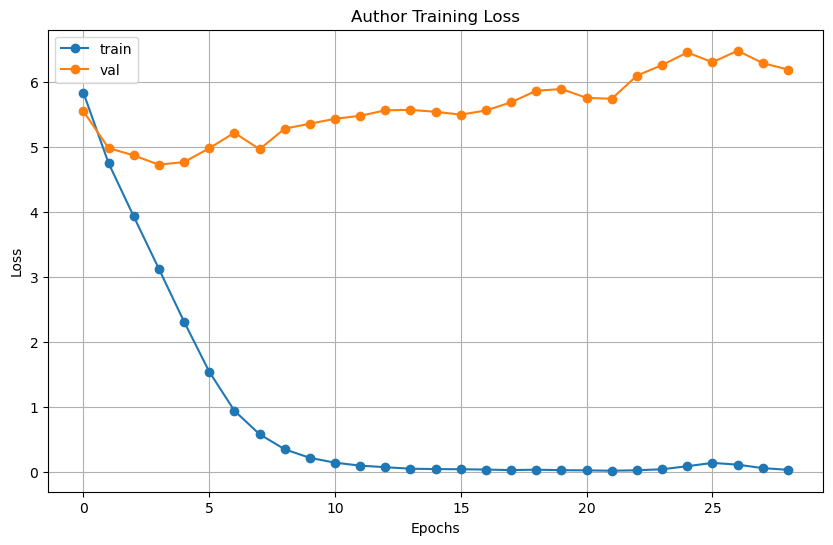

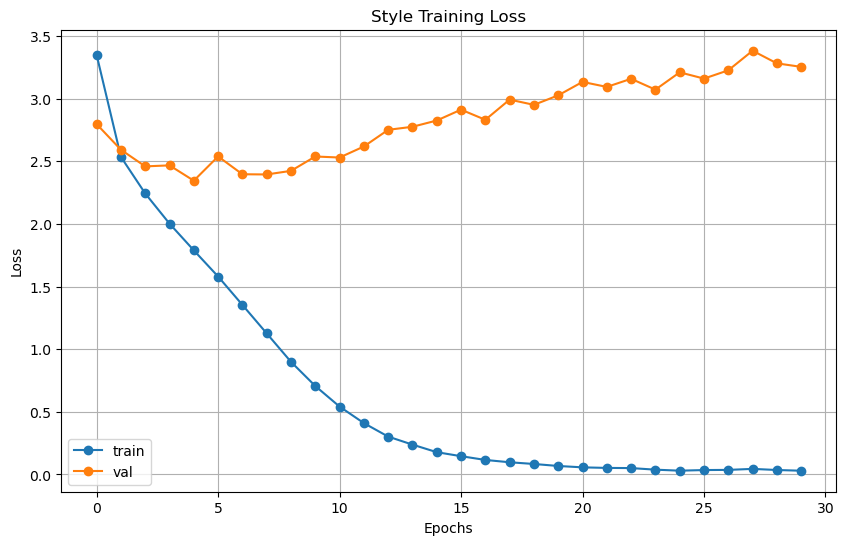

In [ ]:
plot_loss([auth_train_losses,auth_test_loss], "Author Training Loss")
plot_loss([style_train_losses,style_test_loss], "Style Training Loss")

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


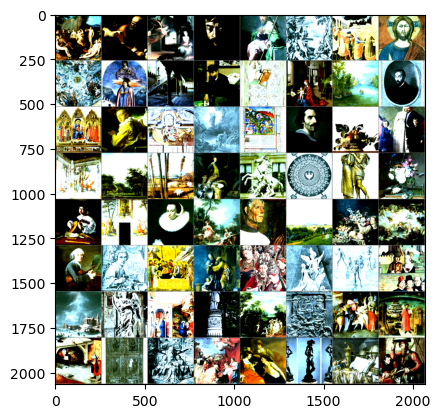

GroundTruth Author:  cornelis van haarlem; caravaggio; beccafumi; caravaggio


IndexError: index 840 is out of bounds for axis 0 with size 758

In [ ]:
dataiter_auth = iter(testloader_auth)
dataiter_style = iter(testloader_style)

images, label_auth = next(dataiter_auth)
images, label_sty = next(dataiter_style)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth Author: ', '; '.join('%5s' % labels_author[label_auth[j]] for j in range(4)))
print('GroundTruth Style: ', '; '.join('%5s' % labels_sty[label_sty[j]] for j in range(4)))

In [ ]:
model_auth.eval()
images = images.to(device)

outputs = model_auth(images)[0].to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', '; '.join('%5s' % labels_author[predicted[j]] for j in range(4)))

Predicted:  cornelis van haarlem; caravaggio; champaigne; eeckhout


In [ ]:
model_style.eval()
images = images.to(device)
outputs = model_auth(images)[0].to(device)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', '; '.join('%5s' % labels_sty[predicted[j]] for j in range(4)))

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 15.99 GiB of which 0 bytes is free. Of the allocated memory 21.82 GiB is allocated by PyTorch, and 301.41 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
calculate_accuracy(testloader_auth, model_auth, criterion, device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 15.99 GiB of which 0 bytes is free. Of the allocated memory 21.80 GiB is allocated by PyTorch, and 315.30 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
calculate_accuracy(testloader_style, model_style, criterion, device)

Accuracy of the network on the test images: 17 %


In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'
torch.save(model_auth.state_dict(), './model_checkpoints/model_auth.pth')
torch.save(model_style.state_dict(), './model_checkpoints/model_style.pth')